In [1]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
torch.cuda.empty_cache()

In [3]:
# By @smth 
import sys
import psutil
import gc

def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

cpuStats()
memReport()

3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]
0.0
svmem(total=17117237248, available=10399232000, percent=39.2, used=6718005248, free=10399232000)
memory GB: 0.13238143920898438


In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load and Transform our Data

We'll be using PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class which makes is very easy to load data from a directory. For example, the training images are all stored in a directory path that looks like this:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

Where, in this case, the root folder for training is `flower_photos/train/` and the classes are the names of flower types.

In [5]:
# define training and test data directories
data_dir = 'flower_data/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'google_test_data/')

In [6]:
# classes are folders in each directory with these names

import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

### Transforming the Data

When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects `224`-dim square images as input and so, we resize each flower image to fit this mold.

In [7]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
# data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
#                                       transforms.ToTensor()])

data_transforms = transforms.Compose([transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.RandomHorizontalFlip(), # randomly flip and rotate
                    transforms.RandomRotation(10),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])

train_data = datasets.ImageFolder(train_dir, transform=data_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(valid_data))

Num training images:  6552
Num test images:  818


### DataLoaders and Data Visualization

In [8]:
# define dataloader parameters
batch_size = 20
num_workers=0


In [9]:
len(train_loader)

328

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyError: '0'

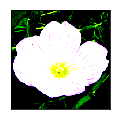

In [27]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
np.clip(images, 0, 1)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(cat_to_name[str(int(labels[idx]))])

---
## Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [13]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [14]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 

4096
1000


In [15]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.require_grad = False
    

---
### Final Classifier Layer

Once you have the pre-trained feature extractor, you just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you repace the last layer in the vgg classifier group of layers. 
> This layer should see as input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task.

You can access any layer in a pretrained network by name and (sometimes) number, i.e. `vgg16.classifier[6]` is the sixth layer in a group of layers named "classifier".

In [16]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs,len(cat_to_name))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

102


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Below we'll use cross-entropy loss and stochastic gradient descent with a small learning rate. Note that the optimizer accepts as input _only_ the trainable parameters `vgg.classifier.parameters()`.

In [17]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
# optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.00001, amsgrad=True, eps=1e-8, weight_decay=1e-5 )

---
## Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help.

## Continue training

In [18]:
def load_checkpoint(model,filename):
    if os.path.isfile(filename):
        print("=> loading model '{}'".format(filename))
        model.load_state_dict(torch.load(filename))
        print("=> loaded model from '{}'".format(filename))
    else:
        print("=> no model found at '{}'".format(filename))

    return model

In [20]:
model = load_checkpoint(vgg16, 'models/model_flower_vgg_3.pt')

=> loading model 'models/model_flower_vgg_3.pt'
=> loaded model from 'models/model_flower_vgg_3.pt'


---
## Testing

Below you see the test accuracy for each flower class.

In [28]:
data_transforms = transforms.Compose([transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])

test_data = datasets.ImageFolder(test_dir, transform=data_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [29]:
len(test_loader)

50

In [32]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(class_total)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (
            cat_to_name[str(i+1)], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

d:\Anaconda3\envs\evforpytorch\lib\site-packages\PIL\Image.py:2655: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


OSError: cannot identify image file <_io.BufferedReader name='flower_data/google_test_data/36\\5. single-crimson-cattleya-rubylipped-labiata-260nw-556853779.jpg'>

### Visualize Sample Test Results

In [23]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images_ = images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images_[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format( cat_to_name[str(int(preds[idx])+1)], cat_to_name[str(int(labels[idx])+1)]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
    


RuntimeError: CUDA out of memory. Tried to allocate 61.25 MiB (GPU 0; 8.00 GiB total capacity; 6.07 GiB already allocated; 25.17 MiB free; 176.35 MiB cached)